# Graph-based Recommender using PageRank for Fashion Recommendation

**Social Media Analytics Exam Project (Yohanes Nuwara)**

The data is obtained from: https://cseweb.ucsd.edu/~jmcauley/datasets.html#clothing_fit.

This work is original. I cracked the algorithm and build it myself :)

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import json
import csv
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

import matplotlib.pyplot as plt

plt.style.use('ggplot')


# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
import networkx as nx
from itertools import combinations

## Convert reviews in JSON to keywords in CSV

Read JSON file

In [ ]:

# Read the JSON file
with open('/content/drive/MyDrive/BABD/Web analytics Exam/renttherunway_final_data.json', 'r') as file:
    lines = file.readlines()

# Print only the first 10 lines to avoid excessive output
for line in lines[:10]:
    try:
        data = json.loads(line.strip())
        print(data)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")

{'fit': 'fit', 'user_id': '420272', 'bust size': '34d', 'item_id': '2260466', 'weight': '137lbs', 'rating': '10', 'rented for': 'vacation', 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.", 'body type': 'hourglass', 'review_summary': 'So many compliments!', 'category': 'romper', 'height': '5\' 8"', 'size': 14, 'age': '28', 'review_date': 'April 20, 2016'}
{'fit': 'fit', 'user_id': '273551', 'bust size': '34b', 'item_id': '153475', 'weight': '132lbs', 'rating': '10', 'rented for': 'other', 'review_text': 'I rented this dress for a photo shoot. The theme was "Hollywood Glam and Big Beautiful Hats". The dress was very comfortable and easy to move around in. It is definitely on my list to rent again for another formal event. ', 'body type': 'straight & narrow', 'review_summary': 'I felt so glamourous!!!

Convert JSON to CSV

In [ ]:

# Define the input file and output CSV file names
input_file = '/content/drive/MyDrive/BABD/Web analytics Exam/renttherunway_final_data.json'
output_file = '/content/renttherunway_final_data.csv'

# Read the JSON file and split it into separate JSON objects
with open(input_file, 'r') as file:
    file_content = file.read()

# Split content into individual JSON objects
json_objects = file_content.strip().split('\n')

# Parse JSON objects and collect them into a list
data = []
for obj in json_objects:
    try:
        data.append(json.loads(obj))
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")

# Write the list of dictionaries to a CSV file
with open(output_file, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the header (keys from the first dictionary)
    if data:
        header = data[0].keys()
        csv_writer.writerow(header)

        # Write the data (values from each dictionary)
        for item in data:
            csv_writer.writerow(item.values())


In [ ]:
# Read CSV
df = pd.read_csv("/content/renttherunway_final_data.csv")

df

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,116,4,1063761,10,party,This hugged in all the right places! It was a ...,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",360448,"December 14, 2015",NaN,NaN,NaN
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192539,fit,66386,34dd,2252812,140lbs,10,work,Fit like a glove!,hourglass,LOVE IT!!! First Item Im thinking of buying!,jumpsuit,"5' 9""",8,42,"May 18, 2016"
192540,fit,118398,32c,682043,100lbs,10,work,The pattern contrast on this dress is really s...,petite,LOVE it!,dress,"5' 1""",4,29,"September 30, 2016"
192541,fit,47002,36a,683251,135lbs,6,everyday,"Like the other DVF wraps, the fit on this is f...",straight & narrow,"Loud patterning, flattering fit",dress,"5' 8""",8,31,"March 4, 2016"
192542,fit,961120,36c,126335,165lbs,10,wedding,This dress was PERFECTION. it looked incredib...,pear,loved this dress it was comfortable and photog...,dress,"5' 6""",16,31,"November 25, 2015"


In [ ]:
# Convert the 'rating' column to numeric, forcing non-numeric values to NaN
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Remove rows where 'rating' is NaN
df = df.dropna(subset=['rating'])

df

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"
5,fit,734848,32b,364092,138lbs,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,"5' 8""",8,45,"April 30, 2016"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192539,fit,66386,34dd,2252812,140lbs,10.0,work,Fit like a glove!,hourglass,LOVE IT!!! First Item Im thinking of buying!,jumpsuit,"5' 9""",8,42,"May 18, 2016"
192540,fit,118398,32c,682043,100lbs,10.0,work,The pattern contrast on this dress is really s...,petite,LOVE it!,dress,"5' 1""",4,29,"September 30, 2016"
192541,fit,47002,36a,683251,135lbs,6.0,everyday,"Like the other DVF wraps, the fit on this is f...",straight & narrow,"Loud patterning, flattering fit",dress,"5' 8""",8,31,"March 4, 2016"
192542,fit,961120,36c,126335,165lbs,10.0,wedding,This dress was PERFECTION. it looked incredib...,pear,loved this dress it was comfortable and photog...,dress,"5' 6""",16,31,"November 25, 2015"


In [ ]:
df.review_text[0]

"An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments."

Remove rows which review_text column has NaN

In [ ]:
df = df.dropna(subset=['review_text'])

df

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"
5,fit,734848,32b,364092,138lbs,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,"5' 8""",8,45,"April 30, 2016"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192539,fit,66386,34dd,2252812,140lbs,10.0,work,Fit like a glove!,hourglass,LOVE IT!!! First Item Im thinking of buying!,jumpsuit,"5' 9""",8,42,"May 18, 2016"
192540,fit,118398,32c,682043,100lbs,10.0,work,The pattern contrast on this dress is really s...,petite,LOVE it!,dress,"5' 1""",4,29,"September 30, 2016"
192541,fit,47002,36a,683251,135lbs,6.0,everyday,"Like the other DVF wraps, the fit on this is f...",straight & narrow,"Loud patterning, flattering fit",dress,"5' 8""",8,31,"March 4, 2016"
192542,fit,961120,36c,126335,165lbs,10.0,wedding,This dress was PERFECTION. it looked incredib...,pear,loved this dress it was comfortable and photog...,dress,"5' 6""",16,31,"November 25, 2015"


In [ ]:
# Function to extract keywords
def extract_keywords_nltk(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha()]  # Remove punctuation and numbers
    words = [word for word in words if word.lower() not in stop_words]
    pos_tags = pos_tag(words)
    keywords = [word for word, pos in pos_tags if pos in ['NN', 'NNS', 'JJ', 'JJR', 'JJS']]
    return keywords

# Apply the function to the review_text column
df['keywords'] = df['review_text'].apply(extract_keywords_nltk)

# Print the DataFrame with keywords
df[['review_text', 'keywords']]

<ipython-input-22-eef65f870f3d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keywords'] = df['review_text'].apply(extract_keywords_nltk)


,review_text,keywords
0,An adorable romper! Belt and zipper were a lit...,"[adorable, romper, little, hard, navigate, ful..."
1,I rented this dress for a photo shoot. The the...,"[dress, photo, shoot, theme, dress, comfortabl..."
3,I rented this for my company's black tie award...,"[company, black, tie, awards, banquet, dress, ..."
4,I have always been petite in my upper body and...,"[petite, upper, body, athletic, size, due, fac..."
5,Didn't actually wear it. It fit perfectly. The...,"[wear, fit, fabric, little, thicker, higher, q..."
...,...,...
192539,Fit like a glove!,[glove]
192540,The pattern contrast on this dress is really s...,"[pattern, contrast, dress, rent, fine, wrap, d..."
192541,"Like the other DVF wraps, the fit on this is f...","[fit, fantastic, collar, drops, low, cinch, wr..."
192542,This dress was PERFECTION. it looked incredib...,"[dress, incredible, photos, girl, party, incre..."


In [ ]:
df.to_csv("/content/renttherunway_final_data.csv", index=False)

## Keywords to network graph

In [4]:
# Read CSV
df = pd.read_csv("/content/drive/MyDrive/BABD/Web analytics Exam/renttherunway_final_data.csv")

df

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,keywords
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016","['adorable', 'romper', 'little', 'hard', 'navi..."
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013","['dress', 'photo', 'shoot', 'theme', 'dress', ..."
2,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014","['company', 'black', 'tie', 'awards', 'banquet..."
3,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016","['petite', 'upper', 'body', 'athletic', 'size'..."
4,fit,734848,32b,364092,138lbs,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,"5' 8""",8,45,"April 30, 2016","['wear', 'fit', 'fabric', 'little', 'thicker',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162102,fit,66386,34dd,2252812,140lbs,10.0,work,Fit like a glove!,hourglass,LOVE IT!!! First Item Im thinking of buying!,jumpsuit,"5' 9""",8,42,"May 18, 2016",['glove']
162103,fit,118398,32c,682043,100lbs,10.0,work,The pattern contrast on this dress is really s...,petite,LOVE it!,dress,"5' 1""",4,29,"September 30, 2016","['pattern', 'contrast', 'dress', 'rent', 'fine..."
162104,fit,47002,36a,683251,135lbs,6.0,everyday,"Like the other DVF wraps, the fit on this is f...",straight & narrow,"Loud patterning, flattering fit",dress,"5' 8""",8,31,"March 4, 2016","['fit', 'fantastic', 'collar', 'drops', 'low',..."
162105,fit,961120,36c,126335,165lbs,10.0,wedding,This dress was PERFECTION. it looked incredib...,pear,loved this dress it was comfortable and photog...,dress,"5' 6""",16,31,"November 25, 2015","['dress', 'incredible', 'photos', 'girl', 'par..."


Changing format of keywords column in the dataframe

In [5]:
import ast

# Convert strings that look like lists to actual lists
df['keywords'] = df['keywords'].apply(ast.literal_eval)

# Convert lists to the desired string format
df['keywords'] = df['keywords'].apply(lambda x: ', '.join(x) + ', ')

df.keywords

0         adorable, romper, little, hard, navigate, full...
1         dress, photo, shoot, theme, dress, comfortable...
2         company, black, tie, awards, banquet, dress, s...
3         petite, upper, body, athletic, size, due, fact...
4         wear, fit, fabric, little, thicker, higher, qu...
                                ...                        
162102                                              glove, 
162103    pattern, contrast, dress, rent, fine, wrap, dr...
162104    fit, fantastic, collar, drops, low, cinch, wra...
162105    dress, incredible, photos, girl, party, incred...
162106    dress, wonderful, wear, fit, meat, thighs, cle...
Name: keywords, Length: 162107, dtype: object

In this project, I want to focus on keywords of items shared by users which give perfect rating of 10

In [6]:
df_selection = df[df.rating==10]

df_selection.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,keywords
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016","adorable, romper, little, hard, navigate, full..."
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013","dress, photo, shoot, theme, dress, comfortable..."
3,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016","petite, upper, body, athletic, size, due, fact..."
5,fit,336066,34c,568429,112lbs,10.0,everyday,This dress is so sweet. I loved the print. The...,hourglass,LITERALLY THE CUTEST DRESS EVER,dress,"5' 3""",4,27,"December 7, 2017","dress, sweet, print, fit, loose, tie, waist, f..."
6,fit,86661,34d+,130259,118lbs,10.0,formal affair,Fit was great. Maybe a little tight under the ...,full bust,"Great dress, beautifully made. I received lot...",dress,"5' 3""",8,65,"January 1, 2013","great, little, tight, arms,"


Create bipartite network between user_id and item_id, and add attributes e.g. age, bust size, weight, height, category they prefer, body type, and keywords to the item_id node

In [7]:
# Ensure no duplicates in user_id and item_id
customer_nodes = df_selection['user_id'].unique().tolist()
item_nodes = df_selection['item_id'].unique().tolist()

# Construct the bipartite graph
B = nx.Graph()


In [8]:
# Create bipartite network
B.add_nodes_from(customer_nodes, bipartite=0)  # Customers
B.add_nodes_from(item_nodes, bipartite=1)  # Items

# Add edges based on customer-item interactions
for _, row in df_selection.iterrows():
    B.add_edge(row['user_id'], row['item_id'])

In [9]:
# Add customer attributes
for _, row in df_selection.iterrows():
    B.nodes[row['user_id']]['age'] = row['age']
    B.nodes[row['user_id']]['body_type'] = row['body type']
    B.nodes[row['user_id']]['keywords'] = row['keywords']
    B.nodes[row['user_id']]['category'] = row['category']
    B.nodes[row['user_id']]['bust size'] = row['bust size']
    B.nodes[row['user_id']]['height'] = row['height']
    B.nodes[row['user_id']]['weight'] = row['weight']


# Add item keywords
for _, row in df_selection.iterrows():
    B.nodes[row['item_id']]['keywords'] = row['keywords']

In [10]:
# Ensure the graph has no isolated nodes
B.remove_nodes_from(list(nx.isolates(B)))

In [11]:
# Projected graph on items
G_items = nx.bipartite.weighted_projected_graph(B, item_nodes)

## Extract graph for visualization

I want to study the user preference on items based on the similar keywords they share about "seasons". The keywords are: summer, sprint, winter, autumn. I extract the graph subset as gexf file and visualize using [Retina](https://ouestware.gitlab.io/retina/1.0.0-beta.1/#/)

In [ ]:
# Identify items with the keyword 'summer'
items_with_booth = [item for item, attrs in B.nodes(data=True) if attrs.get('keywords') and 'summer' in attrs['keywords']]

# Subgraph with only items containing the keyword 'booth' and their connected customers
subgraph_nodes = set()
for item in items_with_booth:
    subgraph_nodes.add(item)
    subgraph_nodes.update(B.neighbors(item))

subgraph = B.subgraph(subgraph_nodes)

In [ ]:
nx.write_gexf(subgraph, "fashion_summer.gexf")

## Build recommender system

First step, calculate the PageRank. Second, sort from highest score and pick 3 highest. Finally, list down the top 3 items for every user.

In [12]:
# Personalized PageRank
def personalized_pagerank(B, user_id, alpha=0.85):
    personalization = {node: 0 for node in B.nodes}
    personalization[user_id] = 1
    return nx.pagerank(B, alpha=alpha, personalization=personalization, weight='weight')

# Recommendation function
def recommend_items(user_id, df, B, top_n=3):
    pagerank_scores = personalized_pagerank(B, user_id)

    # Filter out items already interacted with by the customer
    interacted_items = set(df[df['user_id'] == user_id]['item_id'])

    # Sort items based on PageRank scores and filter out already interacted items
    recommendations = [
        item for item, score in sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)
        if item not in interacted_items and item in df['item_id'].values
    ]

    return recommendations[:top_n]

In [13]:
# Pick 10 users and print the profile age and keywords they use
user_test = df_selection.iloc[:10,:]

user_test

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,keywords
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016","adorable, romper, little, hard, navigate, full..."
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013","dress, photo, shoot, theme, dress, comfortable..."
3,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016","petite, upper, body, athletic, size, due, fact..."
5,fit,336066,34c,568429,112lbs,10.0,everyday,This dress is so sweet. I loved the print. The...,hourglass,LITERALLY THE CUTEST DRESS EVER,dress,"5' 3""",4,27,"December 7, 2017","dress, sweet, print, fit, loose, tie, waist, f..."
6,fit,86661,34d+,130259,118lbs,10.0,formal affair,Fit was great. Maybe a little tight under the ...,full bust,"Great dress, beautifully made. I received lot...",dress,"5' 3""",8,65,"January 1, 2013","great, little, tight, arms,"
7,fit,154309,32b,1729232,114lbs,10.0,formal affair,The dress was very flattering and fit perfectl...,petite,This dress was everything! It was perfect for ...,gown,"5' 3""",1,33,"October 17, 2016","dress, fit, hips, things, fit, small, chest, f..."
10,fit,87660,36a,1295171,120lbs,10.0,party,The S was snug but in a good way. I wore a pus...,straight & narrow,This dress made me feel so confident & sexy!,sheath,"5' 6""",8,26,"July 28, 2016","good, way, push, bra, dress, look, wore, spanx..."
12,fit,721308,34b,123793,118lbs,10.0,formal affair,"Fit great, super flattering",athletic,Stunning gown. Wore this for heart ball and re...,gown,"5' 5""",2,32,"May 29, 2014","great, super, flattering,"
13,fit,829124,34c,2595752,140lbs,10.0,party,Medium would have been a better fit but large ...,hourglass,These leggings are awesome!,leggings,"5' 7""",20,30,"May 16, 2016","large, night, Pants, high, wouldve, cute, crop..."
14,fit,499943,34c,909221,170lbs,10.0,vacation,This dress is just darling. I would absolutely...,pear,Really cute and comfortable.,dress,"5' 8""",20,35,"March 28, 2017","dress, fits, true, size, little, room, larger,..."


In [14]:
# Apply the algorithm
user_test_id = user_test['user_id']

user_test_id.apply(lambda x: recommend_items(x, user_test, B, top_n=3))

0     [1295171, 123793, 2595752]
1       [123793, 616682, 130259]
3       [123793, 153475, 130259]
5     [123793, 1729232, 2260466]
6       [123793, 153475, 616682]
7       [123793, 130259, 153475]
10     [123793, 130259, 1729232]
12     [1729232, 130259, 153475]
13     [123793, 130259, 1295171]
14      [123793, 130259, 153475]
Name: user_id, dtype: object

## Visualize PageRank of a user

In [21]:
def get_user_pagerank_scores(user_id, df, B, alpha=0.85):
  pagerank_scores = personalized_pagerank(B, user_id, alpha)

  # Sort items by PageRank score (descending order)
  sorted_scores = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)

  # Extract item IDs and PageRank scores into separate lists
  item_ids = [item_id for item_id, score in sorted_scores]
  item_scores = [score for item_id, score in sorted_scores]

  return item_ids, item_scores

In [26]:
# User ID
user_id_to_print = 420272
item_ids, item_scores = get_user_pagerank_scores(user_id_to_print, df, B)


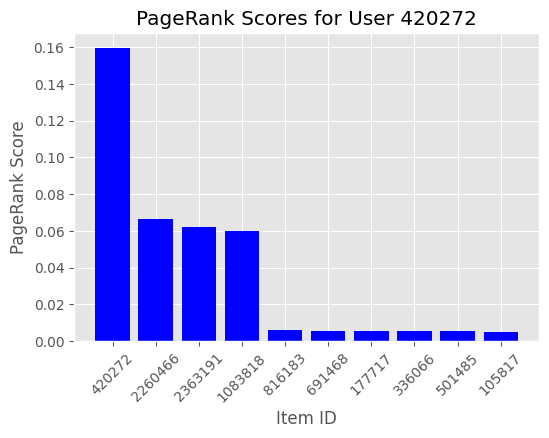

In [29]:
item_ids = [str(item) for item in item_ids]

plt.figure(figsize=(6,4))
plt.bar(item_ids[:10], item_scores[:10], color='b')
# Add labels and title
plt.xlabel("Item ID")
plt.ylabel("PageRank Score")
plt.title(f"PageRank Scores for User {user_id_to_print}")

# Rotate x-axis labels for better readability if there are many items
plt.xticks(rotation=45)

# Display the plot
plt.show()

## Deploy the recommender

I want to implement this algorithm to recommend items to "new user" which has certain profile and have keyword of preference, but I have error. Maybe I will leave it for next and improve :)

In [ ]:
# # Create user profile
# user_id = ['1234']
# age = [34]
# category = ['gown']
# bust_size = ['32b']
# height = [f"{5}' {6}\""]
# weight = ['118lbs']
# item_id = [2260466]

# # Create keyword they prefer
# keyword = ['summer, photo']

# user_profile = pd.DataFrame({"user_id": user_id, "age": age, "category": category,
#                              "bust size": bust_size, "height": height, "weight": weight,
#                              "item_id": item_id, "keywords": keyword})

# user_profile

In [ ]:
# def personalized_pagerank(B, user_id, alpha=0.85):
#     personalization = {node: 0 for node in B.nodes}
#     personalization[user_id] = 1

#     # Avoid division by zero for personalization
#     for node, score in personalization.items():
#         if score == 0:
#             personalization[node] = 1e-8  # Assign a small non-zero value

#     return nx.pagerank(B, alpha=alpha, personalization=personalization, weight='weight')


In [ ]:
# user_profile['user_id'].apply(lambda x: recommend_items(x, user_profile, B, top_n=3))